### Ответы на вопросы

Что такое leave-one-out? Укажите ограничения и сильные стороны.

LOO использует экстремальное соотношение train/test

 Оно отлично подходит когла данных мало.
 
Но плохо работает, когда:

•	есть шум

•	dataset большой

•	модель тяжёлая

Как работают поиск по сетке, рандомизированный поиск по сетке и байесовская оптимизация?

Объясните классификацию методов отбора признаков. Объясните, как работают алгоритмы Пирсона и Хи-квадрат. Объясните, как работает алгоритм Лассо. Объясните, что такое значимость перестановки.

### Введение

In [1]:
import pandas as  pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

import shap
import ast  
import time
import random
import optuna


/Users/affiliation/school21/ML3_Validation.ID_1254800-1/.ml_3_venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_train = pd.read_json("../data/train.json")
df_test = pd.read_json("../data/test.json")

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


In [4]:
print(df_train['created'].min())
print(df_train['created'].max())

2016-04-01 22:12:41
2016-06-29 21:41:47


In [5]:
df_train.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


### Предварительная обработка

In [6]:
cols_to_keep_train = ['bathrooms', 'bedrooms', 'interest_level', 'created', 'price', 'features']
cols_to_keep_test  = ['bathrooms', 'bedrooms', 'features', 'created', 'price']

df_train = df_train[cols_to_keep_train].copy()
df_test  = df_test[cols_to_keep_test].copy()

df_train.head()

,bathrooms,bedrooms,interest_level,created,price,features
4,1.0,1,medium,2016-06-16 05:55:27,2400,"[Dining Room, Pre-War, Laundry in Building, Di..."
6,1.0,2,low,2016-06-01 05:44:33,3800,"[Doorman, Elevator, Laundry in Building, Dishw..."
9,1.0,2,medium,2016-06-14 15:19:59,3495,"[Doorman, Elevator, Laundry in Building, Laund..."
10,1.5,3,medium,2016-06-24 07:54:24,3000,[]
15,1.0,0,low,2016-06-28 03:50:23,2795,"[Doorman, Elevator, Fitness Center, Laundry in..."


In [7]:
q_low, q_high = df_train['price'].quantile([0.01, 0.99])

df_train = df_train[(df_train['price'] > q_low) & (df_train['price'] < q_high)]
df_test  = df_test[(df_test['price'] > q_low) & (df_test['price'] < q_high)]

In [8]:
empty_features_count = df_train['features'].apply(len).eq(0).sum()
print(f"Количество квартир с пустыми features: {empty_features_count}")

df_train = df_train[df_train['features'].apply(len) > 0].reset_index(drop=True)
df_train['features'] = df_train['features'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_test['features']  = df_test['features'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

Количество квартир с пустыми features: 3106


In [9]:
df_train.loc[df_train['bathrooms'] > 4.0, 'bathrooms'] = df_train['bathrooms'].mean()
df_test.loc[df_test['bathrooms'] > 4.0, 'bathrooms'] = df_test['bathrooms'].mean() 

In [10]:
le = LabelEncoder()
df_train['interest_level_encoded'] = le.fit_transform(df_train['interest_level'])

In [11]:
for index, flat_features in enumerate(df_train['features']):
    list_features = {'Elevator', 'Hardwood Floors', 'Cats Allowed', 'Dogs Allowed', 'Doorman', 'Dishwasher', 'No Fee', 'Laundry in Building', 'Fitness Center', 'Pre-War', 'Laundryin Unit', 'Roof Deck', 'Outdoor Space', 'Dining Room', 'High Speed Internet', 'Balcony', 'Swimming Pool', 'Laundry In Building', 'New Construction', 'Terrace'}
    for feature in flat_features:
        if feature in list_features:
            df_train.loc[index, feature] = 1
            list_features.remove(feature)
            
    for feature in list_features:
        df_train.loc[index, feature] = 0
            

In [12]:
flat_features  

['Dining Room',
 'Elevator',
 'Laundry in Building',
 'Dishwasher',
 'Hardwood Floors',
 'No Fee']

In [13]:
df_train.columns

Index(['bathrooms', 'bedrooms', 'interest_level', 'created', 'price',
       'features', 'interest_level_encoded', 'Dining Room', 'Pre-War',
       'Laundry in Building', 'Dishwasher', 'Hardwood Floors', 'Dogs Allowed',
       'Cats Allowed', 'Outdoor Space', 'Doorman', 'No Fee', 'Laundryin Unit',
       'New Construction', 'Terrace', 'Balcony', 'Elevator', 'Fitness Center',
       'High Speed Internet', 'Swimming Pool', 'Laundry In Building',
       'Roof Deck'],
      dtype='object')

In [14]:
X = df_train.drop(columns=["interest_level", "price", "features"])
y = df_train['price']  # целевой показатель

### Методы разбиения данных 

In [15]:
def random_split(X, y, test_size=0.2, random_state=None):
    n_samples = len(X)
    indices = np.arange(n_samples)
    # проверка на наличие random_state для воспроизводимости
    if random_state is not None:
        rng = np.random.default_rng(random_state)
        rng.shuffle(indices)
    else:
        np.random.shuffle(indices)
    # преобразование дробного размера тестовой выборки в абсолютное значение
    test_size_abs = int(n_samples * test_size)
    # распределение индексов для обучающей и тестовой выборок
    test_idx = indices[:test_size_abs]
    train_idx = indices[test_size_abs:]
    X_train = X.iloc[train_idx]
    X_test  = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test  = y.iloc[test_idx]
    return X_train, X_test, y_train, y_test

In [16]:
def random_split_val(X, y, validation_size=0.2, test_size=0.2, random_state=None):
    n_samples = len(X)
    if validation_size + test_size >= 1:
        raise ValueError("validation_size + test_size должен быть < 1")
    indices = np.arange(n_samples)
    if random_state is not None:
        rng = np.random.default_rng(random_state)
        rng.shuffle(indices)
    else:
        np.random.shuffle(indices)
    test_end = int(n_samples * test_size)
    val_end  = test_end + int(n_samples * validation_size)

    test_idx = indices[:test_end]
    val_idx  = indices[test_end:val_end]
    train_idx = indices[val_end:]

    X_train = X.iloc[train_idx]
    X_val   = X.iloc[val_idx]
    X_test  = X.iloc[test_idx]

    y_train = y.iloc[train_idx]
    y_val   = y.iloc[val_idx]
    y_test  = y.iloc[test_idx]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [17]:
def date_split(X, y, date_column, date_split):
    X[date_column] = pd.to_datetime(X[date_column])
    train_mask = X[date_column] < date_split
    test_mask  = X[date_column] >= date_split
    X_train = X[train_mask]
    X_test  = X[test_mask]
    y_train = y[train_mask]
    y_test  = y[test_mask]
    return X_train, X_test, y_train, y_test

In [18]:
print(df_train['created'].min())
print(df_train['created'].max())

2016-04-01 22:12:41
2016-06-29 21:41:47


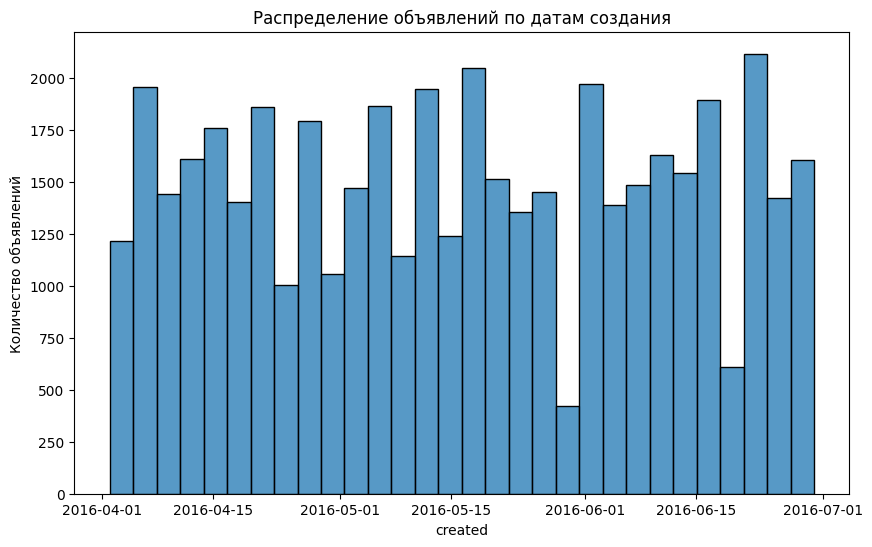

In [19]:
plt.figure(figsize=(10, 6))
df_train['created'] = pd.to_datetime(df_train['created'])
sns.histplot(data=df_train, x='created', bins=30, kde=False)
plt.ylabel('Количество объявлений')
plt.title('Распределение объявлений по датам создания') 
plt.show()

In [20]:
def date_split_val(X, y, date_column, validation_date, test_date):
    X[date_column] = pd.to_datetime(X[date_column])
    val_mask = (X[date_column] >= validation_date) & (X[date_column] < test_date)
    test_mask = X[date_column] >= test_date
    train_mask = ~val_mask & ~test_mask      # ~ и & - это операторы для массивов
    X_train = X[train_mask]
    X_val = X[val_mask]
    X_test = X[test_mask]
    y_train = y[train_mask]
    y_val = y[val_mask]
    y_test = y[test_mask]
    return X_train, X_val, X_test, y_train, y_val, y_test

### Методы перекрестной проверки:

In [21]:
def k_fold(n_samples, k, shuffle=False, random_state=None):
    indices = np.arange(n_samples)

    if shuffle:
        rng = np.random.default_rng(random_state)
        rng.shuffle(indices)

    fold_sizes = np.full(k, n_samples // k, dtype=int) # 
    fold_sizes[:n_samples % k] += 1

    current = 0
    folds = []
    for fold_size in fold_sizes:
        start = current
        stop = current + fold_size
        val_indices = indices[start:stop]
        train_indices = np.concatenate((indices[:start], indices[stop:])) 
        folds.append((train_indices, val_indices))
        current = stop
    return folds

Лучший фолд может отражать случайно благоприятное разбиение данных. Использование среднего значения метрики по всем фолдам позволяет получить более устойчивую и обобщающую оценку качества модели и снизить влияние случайности разбиения.Лучший фолд может отражать случайно благоприятное разбиение данных. Использование среднего значения метрики по всем фолдам позволяет получить более устойчивую и обобщающую оценку качества модели и снизить влияние случайности разбиения.

In [22]:
def group_k_fold(groups, k):
    unique_groups = np.unique(groups)
    n_groups = len(unique_groups)
    group_indices = np.arange(n_groups)

    fold_sizes = np.full(k, n_groups // k, dtype=int)
    fold_sizes[:n_groups % k] += 1

    current = 0
    folds = []
    for fold_size in fold_sizes:

        start = current
        stop = current + fold_size
        
        val_group_indices = group_indices[start:stop]
        train_group_indices = np.concatenate((group_indices[:start], group_indices[stop:]))

        val_groups = unique_groups[val_group_indices]
        train_groups = unique_groups[train_group_indices]

        val_mask = np.isin(groups, val_groups)
        train_mask = np.isin(groups, train_groups)
        train_idx = np.where(train_mask)[0]
        val_idx = np.where(val_mask)[0]

        folds.append((train_idx, val_idx))
        current = stop
    return folds

В K-Fold разбиение происходит по отдельным объектам, поэтому связанные объекты могут попасть одновременно в train и validation, что приводит к утечке информации.

В Group K-Fold разбиение происходит по группам, и все объекты одной группы целиком попадают либо в train, либо в validation, что предотвращает утечку информации между выборками.

In [23]:
def time_series(X, date_field, k):
    X_sorted = X.sort_values(by=date_field)
    indices = X_sorted.index.to_numpy()

    n_samples = len(indices)
    fold_size = n_samples // (k + 1)

    folds = []
    for i in range(k):
        train_end = fold_size * (i + 1)
        val_start = train_end
        val_end = val_start + fold_size

        train_idx = indices[:train_end]
        val_idx = indices[val_start:val_end]

        folds.append((train_idx, val_idx))

    return folds

### Сравнение всех методов проверки

In [24]:
results = []

TARGET = 'interest_level_encoded'
DATE_COL = 'created'

feature_columns = X.columns.drop(DATE_COL)

def build_model_data(X, feature_columns):
    return X[feature_columns].copy()

#### random_split

In [25]:
X_train, X_test, y_train, y_test = random_split(X, y, test_size=0.2, random_state=42)

X_train_model = build_model_data(X_train, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

start = time.perf_counter()

model = LinearRegression()
model.fit(X_train_model, y_train)
test_mae = mean_absolute_error(y_test, model.predict(X_test_model))

elapsed = time.perf_counter() - start

results.append({
    'method': 'random_split',
    'metric': 'MAE',
    'val': np.nan,
    'test': test_mae,
    'time_sec': elapsed
})

#### random_split_val

In [26]:
X_train, X_val, X_test, y_train, y_val, y_test = random_split_val(X, y, validation_size=0.2, test_size=0.2, random_state=None)

X_train_model = build_model_data(X_train, feature_columns)
X_val_model   = build_model_data(X_val, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

start = time.perf_counter()

model = LinearRegression()
model.fit(X_train_model, y_train)

val_mae = mean_absolute_error(y_val, model.predict(X_val_model))
test_mae = mean_absolute_error(y_test, model.predict(X_test_model))

elapsed = time.perf_counter() - start

results.append({
    'method': 'random_split_val',
    'metric': 'MAE',
    'val': val_mae,
    'test': test_mae,
    'time_sec': elapsed
})

#### date_split

In [27]:
X_train, X_test, y_train, y_test = date_split(X, y, date_column='created', date_split='2016-06-01')

X_train_model = build_model_data(X_train, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

start = time.perf_counter()

model = LinearRegression()
model.fit(X_train_model, y_train)
test_mae = mean_absolute_error(y_test, model.predict(X_test_model))

elapsed = time.perf_counter() - start
    
results.append({
    'method': 'date_split',
    'metric': 'MAE',
    'val': np.nan,
    'test': test_mae
})

#### date_split_val

In [28]:
X_train, X_val, X_test, y_train, y_val, y_test = date_split_val(X, y, date_column='created', validation_date='2016-05-20', test_date='2016-06-11')

X_train_model = build_model_data(X_train, feature_columns)
X_val_model   = build_model_data(X_val, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

start = time.perf_counter()

model = LinearRegression()
model.fit(X_train_model, y_train)

val_mae = mean_absolute_error(y_val, model.predict(X_val_model))
test_mae = mean_absolute_error(y_test, model.predict(X_test_model))

elapsed = time.perf_counter() - start

results.append({
    'method': 'date_split_val',
    'metric': 'MAE',
    'val': val_mae,
    'test': test_mae,
    'time_sec': elapsed
})

results_df = pd.DataFrame(results)
print(results_df)

             method metric         val        test  time_sec
0      random_split    MAE         NaN  720.246363  0.023493
1  random_split_val    MAE  693.536942  724.230808  0.009494
2        date_split    MAE         NaN  716.157710       NaN
3    date_split_val    MAE  720.377597  718.660968  0.010446


#### k_fold

In [29]:
splits = k_fold(n_samples=len(X), k=5, shuffle=False, random_state=None)

for train_idx, val_idx in splits:
    X_train_model = X.iloc[train_idx].drop(columns=['created'])
    X_val_model   = X.iloc[val_idx].drop(columns=['created'])

    y_train = y.iloc[train_idx]
    y_val   = y.iloc[val_idx]
    start = time.perf_counter()
    model = LinearRegression()
    model.fit(X_train_model, y_train)
    val_mae = mean_absolute_error(y_val,model.predict(X_val_model))
    
    elapsed = time.perf_counter() - start

results.append({
    'method': 'k_fold',
    'metric': 'MAE',
    'val': np.mean(val_mae),
    'test': np.nan,
    'time_sec': elapsed
})

In [30]:
splits

[(array([ 9048,  9049,  9050, ..., 45234, 45235, 45236], shape=(36189,)),
  array([   0,    1,    2, ..., 9045, 9046, 9047], shape=(9048,))),
 (array([    0,     1,     2, ..., 45234, 45235, 45236], shape=(36189,)),
  array([ 9048,  9049,  9050, ..., 18093, 18094, 18095], shape=(9048,))),
 (array([    0,     1,     2, ..., 45234, 45235, 45236], shape=(36190,)),
  array([18096, 18097, 18098, ..., 27140, 27141, 27142], shape=(9047,))),
 (array([    0,     1,     2, ..., 45234, 45235, 45236], shape=(36190,)),
  array([27143, 27144, 27145, ..., 36187, 36188, 36189], shape=(9047,))),
 (array([    0,     1,     2, ..., 36187, 36188, 36189], shape=(36190,)),
  array([36190, 36191, 36192, ..., 45234, 45235, 45236], shape=(9047,)))]

#### group_k_fold

In [31]:
# splits = group_k_fold(groups, k=5)

В датасете отсутствуют групповые идентификаторы, объединяющие несколько объектов в логически связанные группы. Все признаки описывают характеристики конкретного объявления, а не принадлежность к общей сущности (пользователю, зданию или менеджеру). 

В связи с этим применение Group K-Fold для данного набора данных нецелесообразно и может привести к некорректной оценке качества модели.

#### time_series

In [32]:
splits = time_series(X, date_field='created', k=5)
val_mae_scores = []
for train_idx, val_idx in splits:
    X_train_model = X.iloc[train_idx].drop(columns=['created'])
    X_val_model   = X.iloc[val_idx].drop(columns=['created'])

    y_train = y.iloc[train_idx]
    y_val   = y.iloc[val_idx]
    
    start = time.perf_counter()

    model = LinearRegression()
    model.fit(X_train_model, y_train)
    val_mae = mean_absolute_error(y_val, model.predict(X_val_model))
    val_mae_scores.append(val_mae)

    elapsed = time.perf_counter() - start

results.append({
    'method': 'time_series',
    'metric': 'MAE',
    'val': np.mean(val_mae_scores),
    'test': np.nan,
    'time_sec': elapsed
})

In [33]:
results_df = pd.DataFrame(results)
print(results_df)

             method metric         val        test  time_sec
0      random_split    MAE         NaN  720.246363  0.023493
1  random_split_val    MAE  693.536942  724.230808  0.009494
2        date_split    MAE         NaN  716.157710       NaN
3    date_split_val    MAE  720.377597  718.660968  0.010446
4            k_fold    MAE  716.675675         NaN  0.010146
5       time_series    MAE  713.538933         NaN  0.011163


#### Применяю соответствующие методы из библиотеки sklearn.

#### train_test_split (sklearn)

In [34]:
X_model = X.drop(columns=['created'])
y_model = y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_model = build_model_data(X_train, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

start = time.perf_counter()

model = LinearRegression()
model.fit(X_train_model, y_train)
test_mae = mean_absolute_error(y_test, model.predict(X_test_model))

elapsed = time.perf_counter() - start

results.append({
    'method': 'train_test_split (sklearn)',
    'metric': 'MAE',
    'val': np.nan,
    'test': test_mae,
    'time_sec': elapsed
})

#### train_test_split val (sklearn)

In [35]:
# 1) отделяем test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_model,
    y_model,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# 2) отделяем val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.25,  
    random_state=42,
    shuffle=True
)

X_train_model = build_model_data(X_train, feature_columns)
X_val_model   = build_model_data(X_val, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

start = time.perf_counter()

model = LinearRegression()
model.fit(X_train_model, y_train)
val_mae = mean_absolute_error(y_val, model.predict(X_val_model))
test_mae = mean_absolute_error(y_test, model.predict(X_test_model))

elapsed = time.perf_counter() - start

results.append({
    'method': 'train_test_split val (sklearn)',
    'metric': 'MAE',
    'val': val_mae,
    'test': test_mae,
    'time_sec': elapsed
})

#### KFold (sklearn)

In [36]:
kf = KFold(n_splits=5, shuffle=False)

mae_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_model)):
    X_train = X_model.iloc[train_idx]
    X_val   = X_model.iloc[val_idx]

    y_train = y_model.iloc[train_idx]
    y_val   = y_model.iloc[val_idx]
    start = time.perf_counter()
    model = LinearRegression()
    model.fit(X_train, y_train)
    val_mae = mean_absolute_error(y_val, model.predict(X_val))

    elapsed = time.perf_counter() - start

    mae_scores.append(val_mae)

results.append({
    'method': 'KFold (sklearn)',
    'metric': 'MAE',
    'val': np.mean(mae_scores),
    'test': np.nan,
    'time_sec': elapsed
})

#### TimeSeriesSplit (sklearn)

In [37]:
X_sorted = X.sort_values('created')
y_sorted = y.loc[X_sorted.index]

X_model = X_sorted.drop(columns=['created'])

tscv = TimeSeriesSplit(n_splits=5)

mae_scores = []

for train_idx, val_idx in tscv.split(X_model):
    X_train = X_model.iloc[train_idx]
    X_val   = X_model.iloc[val_idx]

    y_train = y_sorted.iloc[train_idx]
    y_val   = y_sorted.iloc[val_idx]

    start = time.perf_counter()

    model = LinearRegression()
    model.fit(X_train, y_train)
    mae = mean_absolute_error(y_val, model.predict(X_val))
    mae_scores.append(mae)

    elapsed = time.perf_counter() - start

results.append({
    'method': 'TimeSeriesSplit (sklearn)',
    'metric': 'MAE',
    'val': np.mean(mae_scores),
    'test': np.nan,
    'time_sec': elapsed
})

In [38]:
results_df = pd.DataFrame(results)
print(results_df)

                           method metric         val        test  time_sec
0                    random_split    MAE         NaN  720.246363  0.023493
1                random_split_val    MAE  693.536942  724.230808  0.009494
2                      date_split    MAE         NaN  716.157710       NaN
3                  date_split_val    MAE  720.377597  718.660968  0.010446
4                          k_fold    MAE  716.675675         NaN  0.010146
5                     time_series    MAE  713.538933         NaN  0.011163
6      train_test_split (sklearn)    MAE         NaN  708.028171  0.020189
7  train_test_split val (sklearn)    MAE  719.079888  707.431157  0.010965
8                 KFold (sklearn)    MAE  714.757212         NaN  0.010745
9       TimeSeriesSplit (sklearn)    MAE  713.500549         NaN  0.012207


### Выбор функций

Построение модели регрессии Lasso с нормализованными признаками. Используйте мой метод разделения выборок на 3 части по полям, созданным в соотношении 60/20/20 — обучающая/валидационная/тестовая выборки.

In [39]:
X_train, X_val, X_test, y_train, y_val, y_test = date_split_val(
    X,
    y,
    date_column='created',
    validation_date='2016-05-20',
    test_date='2016-06-11'
)

X_train_model = build_model_data(X_train, feature_columns)
X_val_model   = build_model_data(X_val, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_model)
X_val_scaled   = scaler.transform(X_val_model)
X_test_scaled  = scaler.transform(X_test_model)

lasso = Lasso(alpha=0.1, random_state=42, max_iter=10_000)
lasso.fit(X_train_scaled, y_train)

y_val_pred = lasso.predict(X_val_scaled)
val_mae = mean_absolute_error(y_val, y_val_pred)
y_test_pred = lasso.predict(X_test_scaled)
test_mae = mean_absolute_error(y_test, y_test_pred)

results.append({
    'method': 'Lasso all features',
    'metric': 'MAE',
    'val': val_mae,
    'test': test_mae,
    'time_sec': np.nan
})

In [40]:
lasso_coefs = pd.Series(
    lasso.coef_,
    index=feature_columns
)

lasso_coefs_sorted = lasso_coefs.abs().sort_values(ascending=False)
lasso_coefs_sorted


bathrooms                 743.095404
bedrooms                  510.023602
Doorman                   290.711969
Dishwasher                118.770235
Laundry in Building       113.836699
Fitness Center            109.167027
Dogs Allowed              103.913725
Elevator                   99.749395
Laundry In Building        83.924555
Cats Allowed               72.162461
High Speed Internet        69.836374
No Fee                     65.249771
interest_level_encoded     62.649940
Hardwood Floors            51.688250
Terrace                    45.265745
Dining Room                33.084980
Roof Deck                  32.487216
Balcony                    21.289303
Outdoor Space              17.107554
Swimming Pool              10.365537
Pre-War                     8.663526
New Construction            0.339712
Laundryin Unit              0.000000
dtype: float64

In [41]:
top_10_features = lasso_coefs_sorted.head(10).index.tolist()

X_train_top10 = X_train[top_10_features]
X_val_top10   = X_val[top_10_features]
X_test_top10  = X_test[top_10_features]
scaler_tonp10 = StandardScaler()

X_train_top10_scaled = scaler_tonp10.fit_transform(X_train_top10)
X_val_top10_scaled   = scaler_tonp10.transform(X_val_top10)
X_test_top10_scaled  = scaler_tonp10.transform(X_test_top10)

In [42]:
lasso_top10 = Lasso(alpha=lasso.alpha, random_state=42, max_iter=10_000)

lasso_top10.fit(X_train_top10_scaled, y_train)

y_val_pred = lasso_top10.predict(X_val_top10_scaled)
val_mae = mean_absolute_error(y_val, y_val_pred)
y_test_pred = lasso_top10.predict(X_test_top10_scaled)
test_mae = mean_absolute_error(y_test, y_test_pred)

results.append({
    'method': 'Lasso / top 10 features',
    'metric': 'MAE',
    'val': val_mae,
    'test': test_mae,
    'time_sec': np.nan
})

In [43]:
results_df = pd.DataFrame(results)
print(results_df)

                            method metric         val        test  time_sec
0                     random_split    MAE         NaN  720.246363  0.023493
1                 random_split_val    MAE  693.536942  724.230808  0.009494
2                       date_split    MAE         NaN  716.157710       NaN
3                   date_split_val    MAE  720.377597  718.660968  0.010446
4                           k_fold    MAE  716.675675         NaN  0.010146
5                      time_series    MAE  713.538933         NaN  0.011163
6       train_test_split (sklearn)    MAE         NaN  708.028171  0.020189
7   train_test_split val (sklearn)    MAE  719.079888  707.431157  0.010965
8                  KFold (sklearn)    MAE  714.757212         NaN  0.010745
9        TimeSeriesSplit (sklearn)    MAE  713.500549         NaN  0.012207
10              Lasso all features    MAE  720.355390  718.648038       NaN
11         Lasso / top 10 features    MAE  729.938035  724.905720       NaN


Реализация метода для простого отбора признаков по соотношению NaN в признаках и корреляции.

In [44]:
def simple_feature_selection(
    X: pd.DataFrame,
    y: pd.Series,
    nan_threshold: float = 0.3,
    top_k: int = 10
):
    nan_ratio = X.isna().mean()
    good_nan_features = nan_ratio[nan_ratio <= nan_threshold].index

    X_clean = X[good_nan_features]

    corr = X_clean.apply(lambda col: col.corr(y)) # считаем корреляцию каждого столбца признака с y (целевой переменной)
    corr_abs = corr.abs().sort_values(ascending=False)

    selected_features = corr_abs.head(top_k).index.tolist()

    return selected_features, corr_abs

In [45]:
selected_features, corr_scores = simple_feature_selection(
    X_train,
    y_train,
    nan_threshold=0.3,
    top_k=10
)

/Users/affiliation/school21/ML3_Validation.ID_1254800-1/.ml_3_venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/affiliation/school21/ML3_Validation.ID_1254800-1/.ml_3_venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Признаки отбирались на основе доли пропусков и абсолютного значения корреляции с целевой переменной. Из рассмотрения исключались признаки с долей пропусков выше порога, после чего выбирались top-K признаков с наибольшей линейной связью с целевой переменной.

In [46]:
corr_scores

bathrooms                 0.680066
bedrooms                  0.557241
Doorman                   0.264122
Fitness Center            0.222480
Dishwasher                0.209954
Dining Room               0.206750
Elevator                  0.196069
Outdoor Space             0.142785
Terrace                   0.131005
Swimming Pool             0.118666
Laundry in Building       0.118370
No Fee                    0.117562
Roof Deck                 0.117526
Balcony                   0.114613
High Speed Internet       0.088165
Hardwood Floors           0.077970
New Construction          0.061921
Dogs Allowed              0.047714
Pre-War                   0.042875
Cats Allowed              0.035384
interest_level_encoded    0.033320
Laundry In Building       0.024532
created                   0.011137
Laundryin Unit                 NaN
dtype: float64

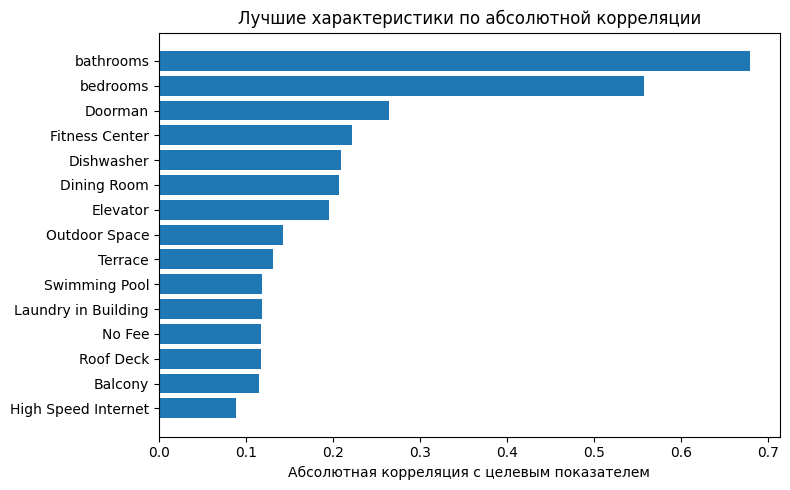

In [47]:

top_corr = corr_scores.head(15)

plt.figure(figsize=(8, 5))
plt.barh(top_corr.index[::-1], top_corr.values[::-1])
plt.xlabel("Абсолютная корреляция с целевым показателем")
plt.title("Лучшие характеристики по абсолютной корреляции")
plt.tight_layout()
plt.show()

In [48]:
X_train_sel = X_train[selected_features]
X_val_sel   = X_val[selected_features]
X_test_sel  = X_test[selected_features]

scaler_fs = StandardScaler()
X_train_sel_scaled = scaler_fs.fit_transform(X_train_sel)
X_val_sel_scaled   = scaler_fs.transform(X_val_sel)
X_test_sel_scaled  = scaler_fs.transform(X_test_sel)

model_fs = Lasso(alpha=0.01, max_iter=10_000, random_state=42)
model_fs.fit(X_train_sel_scaled, y_train)

val_mae_fs = mean_absolute_error(
    y_val,
    model_fs.predict(X_val_sel_scaled)
)

test_mae_fs = mean_absolute_error(
    y_test,
    model_fs.predict(X_test_sel_scaled)
)

results.append({
    'method': 'Feature selection',
    'metric': 'MAE',
    'val': val_mae_fs,
    'test': test_mae_fs,
    'time_sec': np.nan
})

Метод перестановочной важности

In [49]:
def permutation_importance(model, X_val, y_val, metric=mean_absolute_error):
    baseline = metric(y_val, model.predict(X_val))
    importances = {}

    for col in X_val.columns:
        X_permuted = X_val.copy()
        X_permuted[col] = np.random.permutation(X_permuted[col].values)

        permuted_score = metric(y_val, model.predict(X_permuted))
        importances[col] = permuted_score - baseline

    return importances

In [50]:
X_train_model = build_model_data(X_train, feature_columns)
X_val_model   = build_model_data(X_val, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

model = LinearRegression()
model.fit(X_train_model, y_train)

perm_importance = permutation_importance(
    model,
    X_val_model,
    y_val
)

perm_df = (
    pd.Series(perm_importance)
      .sort_values(ascending=False)
)
feature_123 = perm_df.index.tolist()
top_10_features = perm_df.head(10).index.tolist()
print(top_10_features)

['bathrooms', 'bedrooms', 'Doorman', 'Laundry in Building', 'Dishwasher', 'Dogs Allowed', 'Elevator', 'Fitness Center', 'Laundry In Building', 'High Speed Internet']


In [51]:
feature_123

['bathrooms',
 'bedrooms',
 'Doorman',
 'Laundry in Building',
 'Dishwasher',
 'Dogs Allowed',
 'Elevator',
 'Fitness Center',
 'Laundry In Building',
 'High Speed Internet',
 'Cats Allowed',
 'No Fee',
 'Hardwood Floors',
 'interest_level_encoded',
 'Roof Deck',
 'Terrace',
 'Outdoor Space',
 'Dining Room',
 'Balcony',
 'Laundryin Unit',
 'New Construction',
 'Pre-War',
 'Swimming Pool']

In [52]:
X_train_top10 = X_train_model[top_10_features]
X_val_top10   = X_val_model[top_10_features]
X_test_top10  = X_test_model[top_10_features]

model_top10 = LinearRegression()
model_top10.fit(X_train_top10, y_train)

val_mae = mean_absolute_error(y_val, model_top10.predict(X_val_top10))
test_mae = mean_absolute_error(y_test, model_top10.predict(X_test_top10))

results.append({
    'method': 'Permutation importance (top 10)',
    'metric': 'MAE',
    'val': val_mae,
    'test': test_mae,
    'time_sec': np.nan
})

Применение модели Shape

In [53]:
X_train_model = build_model_data(X_train, feature_columns)
X_val_model   = build_model_data(X_val, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

model = LinearRegression()
model.fit(X_train_model, y_train)

explainer = shap.LinearExplainer(model,X_train_model)
shap_values = explainer.shap_values(X_val_model) # получаем матрицу SHAP значений для валидационного набора

shap_importance = (
    pd.DataFrame({
        'feature': X_val_model.columns,
        'importance': np.abs(shap_values).mean(axis=0)  # получаем средний абсолютный вклад признака в предсказание модели
    })
    .sort_values(by='importance', ascending=False) # Сортировка по важности
)

In [54]:
print(shap_importance)

                   feature  importance
0                bathrooms  652.217786
1                 bedrooms  427.165948
11                 Doorman  287.132841
6               Dishwasher  119.931629
5      Laundry in Building  110.097343
8             Dogs Allowed  105.120190
17                Elevator  100.379834
18          Fitness Center  100.278017
9             Cats Allowed   73.690092
12                  No Fee   63.411237
7          Hardwood Floors   51.554605
2   interest_level_encoded   43.536199
19     High Speed Internet   41.761292
21     Laundry In Building   38.550046
3              Dining Room   23.572846
22               Roof Deck   23.307236
15                 Terrace   22.230387
10           Outdoor Space   13.827887
16                 Balcony   13.558736
4                  Pre-War    6.615719
20           Swimming Pool    6.005881
14        New Construction    0.222774
13          Laundryin Unit    0.000000


In [55]:
top_10_features = shap_importance.head(10)['feature'].tolist()

X_train_top10 = X_train_model[top_10_features]
X_val_top10   = X_val_model[top_10_features]
X_test_top10  = X_test_model[top_10_features]

model_top10 = LinearRegression()
model_top10.fit(X_train_top10, y_train)

val_mae = mean_absolute_error(y_val, model_top10.predict(X_val_top10))
test_mae = mean_absolute_error(y_test, model_top10.predict(X_test_top10))

results.append({
    'method': 'SHAP (top 10 features)',
    'metric': 'MAE',
    'val': val_mae,
    'test': test_mae,
    'time_sec': np.nan
})

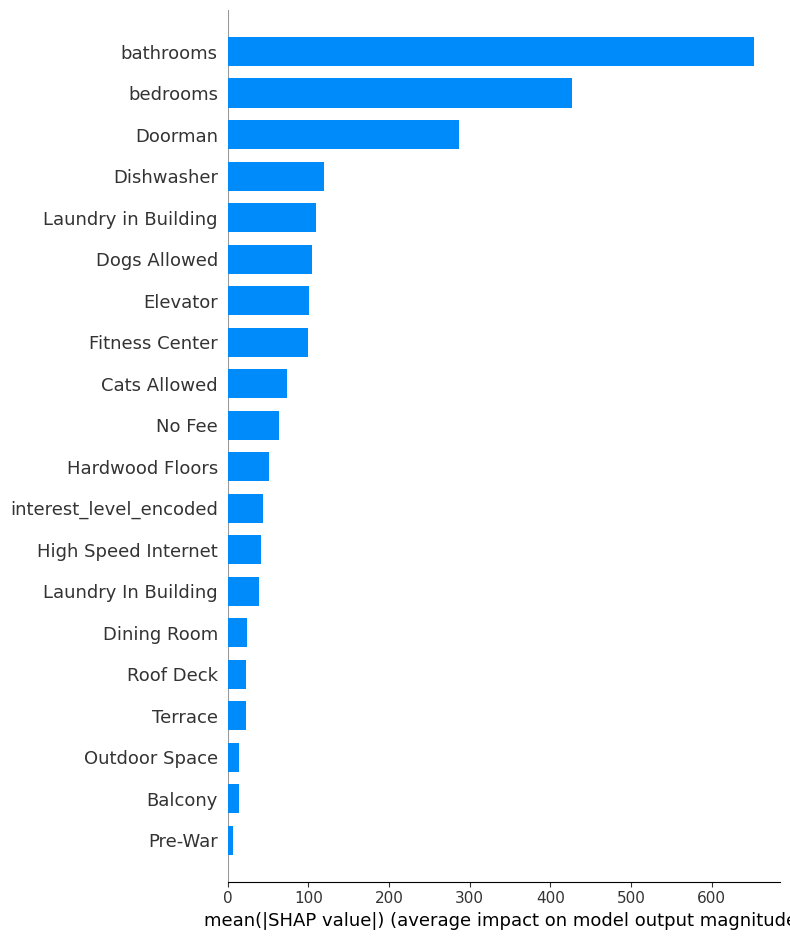

In [56]:
shap.summary_plot(
    shap_values,
    X_val_model,
    plot_type="bar"
)

SHAP-важность рассчитывается как средний абсолютный вклад признака в предсказание модели на валидационной выборке.

In [57]:
df_results = pd.DataFrame(results)
print(df_results)   

                             method metric         val        test  time_sec
0                      random_split    MAE         NaN  720.246363  0.023493
1                  random_split_val    MAE  693.536942  724.230808  0.009494
2                        date_split    MAE         NaN  716.157710       NaN
3                    date_split_val    MAE  720.377597  718.660968  0.010446
4                            k_fold    MAE  716.675675         NaN  0.010146
5                       time_series    MAE  713.538933         NaN  0.011163
6        train_test_split (sklearn)    MAE         NaN  708.028171  0.020189
7    train_test_split val (sklearn)    MAE  719.079888  707.431157  0.010965
8                   KFold (sklearn)    MAE  714.757212         NaN  0.010745
9         TimeSeriesSplit (sklearn)    MAE  713.500549         NaN  0.012207
10               Lasso all features    MAE  720.355390  718.648038       NaN
11          Lasso / top 10 features    MAE  729.938035  724.905720       NaN

                                                                                 Сравнение скоростей


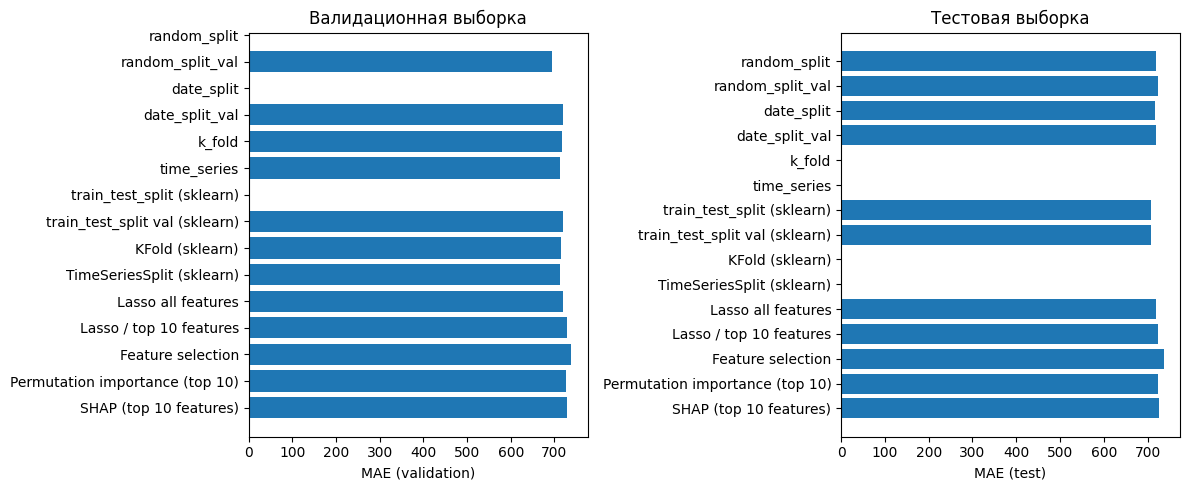

In [58]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

print(80 * ' ', "Сравнение скоростей")

axes[0].barh(df_results['method'], df_results['val'])
axes[0].set_xlabel('MAE (validation)')
axes[0].set_title('Валидационная выборка')
axes[0].invert_yaxis()

axes[1].barh(df_results['method'], df_results['test'])
axes[1].set_xlabel('MAE (test)')
axes[1].set_title('Тестовая выборка')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

### Оптимизация гиперпараметров

#### Оптимизация

Методы перебора по сетке и случайного поиска для параметров alpha и l1_ratio в модели ElasticNet из библиотеки sklearn.

In [59]:
X_train_model = build_model_data(X_train, feature_columns)
X_val_model   = build_model_data(X_val, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_model)
X_val_scaled   = scaler.transform(X_val_model)
X_test_scaled  = scaler.transform(X_test_model)

In [ ]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

best_mae = np.inf 
best_params = None

for alpha in param_grid['alpha']:
    for l1_ratio in param_grid['l1_ratio']:
        model = ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio,
            random_state=42,
            max_iter=10_000
        )
        model.fit(X_train_scaled, y_train)

        val_pred = model.predict(X_val_scaled)
        val_mae = mean_absolute_error(y_val, val_pred)

        if val_mae < best_mae:
            best_mae = val_mae
            best_params = {'alpha': alpha, 'l1_ratio': l1_ratio}

best_model = ElasticNet(
    **best_params, 
    random_state=42,
    max_iter=10_000
)
start = time.perf_counter()

best_model.fit(X_train_scaled, y_train)
test_mae = mean_absolute_error(
    y_test,
    best_model.predict(X_test_scaled)
)
elapsed = time.perf_counter() - start
results.append({
    'method': 'ElasticNet Grid Search',
    'metric': 'MAE',
    'val': best_mae,
    'test': test_mae,
    'time_sec': np.nan
})

In [61]:

alpha_range = np.logspace(-3, 1, 100)
l1_ratio_range = np.linspace(0.1, 0.9, 100)

n_iter = 30
best_mae = np.inf
best_params = None

for _ in range(n_iter):
    alpha = random.choice(alpha_range)
    l1_ratio = random.choice(l1_ratio_range)

    model = ElasticNet(
        alpha=alpha,
        l1_ratio=l1_ratio,
        random_state=42,
        max_iter=10_000
    )

    start = time.perf_counter()
    model.fit(X_train_scaled, y_train)

    val_pred = model.predict(X_val_scaled)
    val_mae = mean_absolute_error(y_val, val_pred)

    if val_mae < best_mae:
        best_mae = val_mae
        best_params = {'alpha': alpha, 'l1_ratio': l1_ratio}


In [62]:
best_model = ElasticNet(
    **best_params,
    random_state=42,
    max_iter=10_000
)
best_model.fit(X_train_scaled, y_train)
elapsed = time.perf_counter() - start
test_mae = mean_absolute_error(
    y_test,
    best_model.predict(X_test_scaled)
)

results.append({
    'method': 'ElasticNet Random Search',
    'metric': 'MAE',
    'val': best_mae,
    'test': test_mae,
    'time_sec': np.nan
})

In [63]:
df_results = pd.DataFrame(results)
print(df_results)

                             method metric         val        test  time_sec
0                      random_split    MAE         NaN  720.246363  0.023493
1                  random_split_val    MAE  693.536942  724.230808  0.009494
2                        date_split    MAE         NaN  716.157710       NaN
3                    date_split_val    MAE  720.377597  718.660968  0.010446
4                            k_fold    MAE  716.675675         NaN  0.010146
5                       time_series    MAE  713.538933         NaN  0.011163
6        train_test_split (sklearn)    MAE         NaN  708.028171  0.020189
7    train_test_split val (sklearn)    MAE  719.079888  707.431157  0.010965
8                   KFold (sklearn)    MAE  714.757212         NaN  0.010745
9         TimeSeriesSplit (sklearn)    MAE  713.500549         NaN  0.012207
10               Lasso all features    MAE  720.355390  718.648038       NaN
11          Lasso / top 10 features    MAE  729.938035  724.905720       NaN

In [64]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

best_mae = np.inf
best_params = None

for alpha in param_grid['alpha']:
    for l1_ratio in param_grid['l1_ratio']:
        model = ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio,
            random_state=42,
            max_iter=10_000
        )
        model.fit(X_train_scaled, y_train)

        val_pred = model.predict(X_val_scaled)
        val_mae = mean_absolute_error(y_val, val_pred)

        if val_mae < best_mae:
            best_mae = val_mae
            best_params = {
                'alpha': alpha,
                'l1_ratio': l1_ratio
            }

In [65]:
best_model = ElasticNet(
    **best_params,
    random_state=42,
    max_iter=10_000
)
best_model.fit(X_train_scaled, y_train)

test_mae = mean_absolute_error(
    y_test,
    best_model.predict(X_test_scaled)
)

In [66]:
print("Best params:", best_params)
print("Validation MAE:", best_mae)
print("Test MAE:", test_mae)

Best params: {'alpha': 0.1, 'l1_ratio': 0.7}
Validation MAE: 719.8884887319413
Test MAE: 718.7208022277867


In [67]:
X_train_final = pd.concat([X_train_model, X_val_model])
y_train_final = pd.concat([y_train, y_val])

scaler = StandardScaler()

X_train_final_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_model)

In [68]:
final_model = ElasticNet(
    alpha=0.1,
    l1_ratio=0.7,
    max_iter=10_000,
    random_state=42
)
final_model.fit(X_train_final_scaled, y_train_final)

y_test_pred = final_model.predict(X_test_scaled)
final_test_mae = mean_absolute_error(y_test, y_test_pred)

results.append({
    'method': 'ElasticNet Model with best params',
    'metric': 'MAE',
    'val': np.nan,
    'test': final_test_mae,
    'time_sec': np.nan
})

In [69]:
df_results = pd.DataFrame(results)
print(df_results)

                               method metric         val        test  time_sec
0                        random_split    MAE         NaN  720.246363  0.023493
1                    random_split_val    MAE  693.536942  724.230808  0.009494
2                          date_split    MAE         NaN  716.157710       NaN
3                      date_split_val    MAE  720.377597  718.660968  0.010446
4                              k_fold    MAE  716.675675         NaN  0.010146
5                         time_series    MAE  713.538933         NaN  0.011163
6          train_test_split (sklearn)    MAE         NaN  708.028171  0.020189
7      train_test_split val (sklearn)    MAE  719.079888  707.431157  0.010965
8                     KFold (sklearn)    MAE  714.757212         NaN  0.010745
9           TimeSeriesSplit (sklearn)    MAE  713.500549         NaN  0.012207
10                 Lasso all features    MAE  720.355390  718.648038       NaN
11            Lasso / top 10 features    MAE  729.93

In [70]:
X_train_model = build_model_data(X_train, feature_columns)
X_val_model   = build_model_data(X_val, feature_columns)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_model)
X_val_scaled   = scaler.transform(X_val_model)

Импорт Optuna и прровожу тот же эксперимент с ElasticNet

In [71]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-3, 1.0, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

    model = ElasticNet(
        alpha=alpha,
        l1_ratio=l1_ratio,
        max_iter=10_000,
        random_state=42
    )

    model.fit(X_train_scaled, y_train)

    y_val_pred = model.predict(X_val_scaled)
    val_mae = mean_absolute_error(y_val, y_val_pred)

    return val_mae

In [72]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2026-01-29 16:13:52,199] A new study created in memory with name: no-name-b79300dc-6921-44af-8ccb-993485a3a146
[I 2026-01-29 16:13:52,226] Trial 0 finished with value: 720.1560319190133 and parameters: {'alpha': 0.01500828940403488, 'l1_ratio': 0.46187226203295106}. Best is trial 0 with value: 720.1560319190133.
[I 2026-01-29 16:13:52,241] Trial 1 finished with value: 719.8921164846307 and parameters: {'alpha': 0.12445157284060517, 'l1_ratio': 0.6875006833867138}. Best is trial 1 with value: 719.8921164846307.
[I 2026-01-29 16:13:52,272] Trial 2 finished with value: 720.3475546485964 and parameters: {'alpha': 0.0021305145178435164, 'l1_ratio': 0.5445739362706503}. Best is trial 1 with value: 719.8921164846307.
[I 2026-01-29 16:13:52,294] Trial 3 finished with value: 720.1592082051028 and parameters: {'alpha': 0.045929856591468594, 'l1_ratio': 0.8331413252179131}. Best is trial 1 with value: 719.8921164846307.
[I 2026-01-29 16:13:52,302] Trial 4 finished with value: 738.4758672238363

In [73]:
study.best_params

{'alpha': 0.08399314850915801, 'l1_ratio': 0.5756352945625605}

In [74]:
study.best_value

719.885040006404

In [75]:
X_train_final = pd.concat([X_train_model, X_val_model])
y_train_final = pd.concat([y_train, y_val])

scaler = StandardScaler()
X_train_final_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_model)

final_model = ElasticNet(
    alpha=study.best_params['alpha'],
    l1_ratio=study.best_params['l1_ratio'],
    max_iter=10_000,
    random_state=42
)

final_model.fit(X_train_final_scaled, y_train_final)

y_test_pred = final_model.predict(X_test_scaled)
final_test_mae = mean_absolute_error(y_test, y_test_pred)

results.append({
    'method': 'ElasticNet Model (Optuna)',
    'metric': 'MAE',
    'val': np.nan,
    'test': final_test_mae,
    'time_sec': np.nan
})

In [76]:
df_results = pd.DataFrame(results)
print(df_results)

                               method metric         val        test  time_sec
0                        random_split    MAE         NaN  720.246363  0.023493
1                    random_split_val    MAE  693.536942  724.230808  0.009494
2                          date_split    MAE         NaN  716.157710       NaN
3                      date_split_val    MAE  720.377597  718.660968  0.010446
4                              k_fold    MAE  716.675675         NaN  0.010146
5                         time_series    MAE  713.538933         NaN  0.011163
6          train_test_split (sklearn)    MAE         NaN  708.028171  0.020189
7      train_test_split val (sklearn)    MAE  719.079888  707.431157  0.010965
8                     KFold (sklearn)    MAE  714.757212         NaN  0.010745
9           TimeSeriesSplit (sklearn)    MAE  713.500549         NaN  0.012207
10                 Lasso all features    MAE  720.355390  718.648038       NaN
11            Lasso / top 10 features    MAE  729.93

В рамках данного исследования были сравнены различные схемы валидации и подбора модели.
Несмотря на то, что случайные разбиения показали наилучшие значения MAE, они являются оптимистичными и потенциально нарушают временную структуру данных.
Наиболее корректным и устойчивым подходом оказался TimeSeriesSplit, как в реализации sklearn, так и в собственной реализации, демонстрируя сопоставимое качество при лучшей интерпретируемости и отсутствии утечек данных.
Методы отбора признаков и регуляризации (Lasso, ElasticNet, SHAP, permutation importance) не привели к улучшению качества, что указывает на распределённую информативность признаков.

#### Запуск optuna на одной из схем перекрестной проверки

In [77]:
X_model = X.drop(columns=['created'])
y_model = y

tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-3, 1.0, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

    mae_scores = []

    for train_idx, val_idx in tscv.split(X_model):
        X_train = X_model.iloc[train_idx]
        X_val   = X_model.iloc[val_idx]

        y_train = y_model.iloc[train_idx]
        y_val   = y_model.iloc[val_idx]

        # масштабирование ТОЛЬКО на train
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled   = scaler.transform(X_val)

        model = ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio,
            max_iter=10_000,
            random_state=42
        )

        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)

        mae = mean_absolute_error(y_val, y_pred)
        mae_scores.append(mae)

    return np.mean(mae_scores)

In [79]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

X_train, X_val, X_test, y_train, y_val, y_test = date_split_val(
    X,
    y,
    date_column='created',
    validation_date='2016-05-20',
    test_date='2016-06-11'
)

X_train_model = build_model_data(X_train, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_model)
X_test_scaled  = scaler.transform(X_test_model)

[I 2026-01-29 16:13:53,293] A new study created in memory with name: no-name-30f740c4-1b05-44da-859c-292d2128a7ba
[I 2026-01-29 16:13:53,383] Trial 0 finished with value: 713.759704521646 and parameters: {'alpha': 0.22535006212091913, 'l1_ratio': 0.7882956408148876}. Best is trial 0 with value: 713.759704521646.
[I 2026-01-29 16:13:53,466] Trial 1 finished with value: 716.6777721533244 and parameters: {'alpha': 0.20259026636728725, 'l1_ratio': 0.2770438430194334}. Best is trial 0 with value: 713.759704521646.
[I 2026-01-29 16:13:53,623] Trial 2 finished with value: 713.7650424195164 and parameters: {'alpha': 0.03467640252824236, 'l1_ratio': 0.001175168671815996}. Best is trial 0 with value: 713.759704521646.
[I 2026-01-29 16:13:53,706] Trial 3 finished with value: 714.0387126060061 and parameters: {'alpha': 0.16312789075539094, 'l1_ratio': 0.5560209023412558}. Best is trial 0 with value: 713.759704521646.
[I 2026-01-29 16:13:53,770] Trial 4 finished with value: 742.6471298586133 and pa

In [ ]:
best_alpha = study.best_params['alpha']
best_l1_ratio = study.best_params['l1_ratio']

final_model = ElasticNet(
    alpha=best_alpha,
    l1_ratio=best_l1_ratio,
    max_iter=10_000,
    random_state=42
)

final_model.fit(X_train_scaled, y_train)

y_test_pred = final_model.predict(X_test_scaled)
test_mae = mean_absolute_error(y_test, y_test_pred)

results.append({
    'method': 'ElasticNet (Optuna + TimeSeriesSplit)',
    'metric': 'MAE',
    'val': np.nan,
    'test': test_mae,
    'time_sec': np.nan
})

In [81]:
df_results = pd.DataFrame(results)
df_results

,method,metric,val,test,time_sec
0,random_split,MAE,NaN,720.246363,0.023493
1,random_split_val,MAE,693.536942,724.230808,0.009494
2,date_split,MAE,NaN,716.157710,NaN
3,date_split_val,MAE,720.377597,718.660968,0.010446
4,k_fold,MAE,716.675675,NaN,0.010146
5,time_series,MAE,713.538933,NaN,0.011163
6,train_test_split (sklearn),MAE,NaN,708.028171,0.020189
7,train_test_split val (sklearn),MAE,719.079888,707.431157,0.010965
8,KFold (sklearn),MAE,714.757212,NaN,0.010745
9,TimeSeriesSplit (sklearn),MAE,713.500549,NaN,0.012207


Подбор гиперпараметров ElasticNet с использованием Optuna и временной перекрёстной проверки (TimeSeriesSplit) не привёл к значимому улучшению качества по сравнению с базовой линейной регрессией.
Это свидетельствует о том, что модель уже близка к оптимальной в рамках линейных зависимостей и текущего набора признаков.